In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
##########################  公用函数    ################

# 获取两站点间的距离
def station_dist(station1_id,station2_id,sta_loc):
    a = list(sta_loc[sta_loc['station_id']==station1_id]['lat'])[0]
    b = list(sta_loc[sta_loc['station_id']==station2_id]['lat'])[0]
    c = list(sta_loc[sta_loc['station_id']==station1_id]['lon'])[0]
    d = list(sta_loc[sta_loc['station_id']==station2_id]['lon'])[0]
    return (a-b)**2+(c-d)**2

# 将站点名称统一转为str
def st_id2_str(df,col):
    str_st,index_i = [],[]
    for i in df.index:
        if '.' not in str(df[col][i]):
            pass
        elif len(str(df[col][i])) == 6:
            str_st.append(str(df[col][i])+'0s')
            index_i.append(i)
        elif len(str(df[col][i])) == 7:
            str_st.append(str(df[col][i])+'s')
            index_i.append(i)
        else:
            pass
    df = df[(df.index).isin(index_i)]
    df[col] = str_st
    return df

# 获取当日活动站点状态信息
def get_status(status_df,sta_loc4):
    N_O_name = pd.read_csv('E:/CitiBike/y0_output/new_old_name.csv',index_col = 0)
    N_O_name = st_id2_str(N_O_name,'short_name') # 转换站点id数据格式
    N_O_name = N_O_name[(N_O_name['legacy_id']).isin(list(status_df['station_id']))]#与状态数据交叠
    N_O_name = N_O_name[(N_O_name['short_name']).isin(list(sta_loc4['station_id']))]#与24日当天活动站点的交叠
    N_O_name.columns = ['station_id','name2']
    temp = pd.merge(N_O_name,status_df,on='station_id')#与状态数据合并
    temp = temp[['name2','num_docks_available','num_bikes_available']]
    temp.columns = ['station_id','docks_available','bikes_available']
    return temp

In [3]:
#####  时间设置
today = '2022-01-24'
hour = 8
DateTime = '2022-01-24 08:56:34'
# 公用变量
hour_str=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [4]:
##### 0. 数据准备
status_df = pd.read_csv("E:/CitiBike/y0_output/2022-01-24-08-56-34.csv",index_col=0)
status_df = status_df[status_df['capacity']!=0]
# 变量准备
sample0 = pd.read_csv("E:/CitiBike/y2_output/sample_SET.csv",index_col=0)
sta_loc4 = sample0[sample0['date']==today][['station_id','lat','lon']]#站点坐标数据
sta_loc4.index = range(len(sta_loc4))
threshold_full = 0.006# 定义“附近站点”的阈值
threshold_empty = 0.003# 对于满站要大于空站，因为还车时骑着车，可接受更大距离，而且 还车需求不可abandoned
del sample0

In [5]:
##### 1. 获取各个状态在 研究 时段之内的 实时库存状态

#-- 1.1 --  研究期间活跃的站点  样本矩阵构建
def min_60_df(status_df,date,hour):
    temp = get_status(status_df,sta_loc4)
    status_df = pd.merge(temp,sta_loc4,on='station_id')#样本集状态数据
    status_df['capacity'] = status_df['docks_available'] + status_df['bikes_available'] #忽略坏掉的车/桩 的 站点容量

    temp = pd.read_csv("E:/CitiBike/ori_data/202201-citibike-tripdata.csv")[['started_at','ended_at','start_station_id','end_station_id','start_lat','start_lng','end_lat','end_lng']]
    temp = st_id2_str(temp,'start_station_id') # 转换站点id数据格式
    temp = st_id2_str(temp,'end_station_id')
    temp['date_hour1'] = [x[0:13] for x in temp['started_at']]
    temp['date_hour2'] = [x[0:13] for x in temp['ended_at']]
    temp1 = temp[temp['date_hour1']==date+' '+hour_str[hour]][['started_at','start_station_id']]
    temp1['co_go'] = [-1 for x in range(len(temp1))]
    temp2 = temp[temp['date_hour2']==date+' '+hour_str[hour]][['ended_at','end_station_id']]
    temp2['co_go'] = [1 for x in range(len(temp2))]
    temp1.columns, temp2.columns = ['at','id','co_go'], ['at','id','co_go']

    #-- 1.2 -- 各个站点的库存发生变化的时间 C2
    C2 = {}
    for station in status_df['station_id']:
        bor = temp1[temp1['id']==station]
        ret = temp2[temp2['id']==station]
        C2[station] = (pd.concat([bor,ret])).sort_values(by="at")
    status_df.index = [str(x)+'s' for x in status_df['station_id']]

    #-- 1.3 -- 跟踪各个站点的库存状态 C3
    C3 = {}
    for station in C2.keys():
        temp = C2[station]
        temp1 = list(temp[temp['at']<=DateTime]['co_go'])
        temp2 = list(temp[temp['at']>DateTime]['co_go'])
        temp3 = [status_df['bikes_available'][str(station)+'s']]
        for i in range(1,len(temp1)+1):
            if len(temp3) > 0:
                temp3.append(temp3[-1] - temp1[-i])
        temp3 = list(reversed(temp3))
        for i in range(len(temp2)):
            if len(temp3) > 0:
                temp3.append(temp3[-1] + temp2[i])
        C3[station] = temp3
    # 标记 full和empty 状态
    for station in C3.keys():
        temp = C3[station] 
        if 0 in temp:
            for i in range(len(temp)):
                if temp[i] <=0:
                    temp[i] = 0
        elif (status_df['capacity'][str(station)+'s'] in C3[station]) and status_df['capacity'][str(station)+'s'] != 0:
            for i in range(len(temp)):
                if temp[i] >= status_df['capacity'][str(station)+'s']:
                    temp[i] = 'full'
        C3[station] = temp

    #-- 1.4 -- 所有站点 60min 每分钟站点状态 C4   0代表空站 full代表满站
    C4 = {}
    for station_id in C2.keys():
        Time_at = list(C2[station_id]['at'])
        if len(Time_at)== 0:
            minute60 =60*[C3[station_id][0]]
        elif len(Time_at)== 1:
            minute60 = (int(Time_at[0][14:16])*[C3[station_id][0]])+((60-int(Time_at[0][14:16]))*[C3[station_id][1]])
        else:
            minute60 = (int(Time_at[0][14:16])*[C3[station_id][0]])
            for i in range(1,len(Time_at)):
                minute60 += (int(Time_at[i][14:16])-int(Time_at[i-1][14:16]))*[C3[station_id][i]]
            minute60 += (60-len(minute60))*[C3[station_id][-1]]
        C4[station_id] = minute60
    min60_status_df = pd.DataFrame(C4)# C4 转为 df
    return C2,min60_status_df

In [6]:
##### 2. 获取失衡站点 在失衡期间的需求溢出输出站点

#获取 发生满站_or_空站的站点 附近站点
def neighbour_stations(full_or_empty,min60_status_df,threshold):
    sta_loc2 = sta_loc4[(sta_loc4['station_id']).isin(min60_status_df.columns)]
    S1 = {}
    for station_id in min60_status_df.columns:
        if full_or_empty in list(min60_status_df[station_id]):
            temp1 = list(sta_loc2[sta_loc2['station_id']==station_id]['lat'])[0]
            temp2 = list(sta_loc2[sta_loc2['station_id']==station_id]['lon'])[0]# 寻找附近的站点 经纬度1大概111千米。0.003为333米
            temp3 = sta_loc2[(sta_loc2['lat']>(temp1-threshold)) & (sta_loc2['lat']<(temp1+threshold))]
            temp4 = temp3[(temp3['lon']>(temp2-threshold)) & (temp3['lon']<(temp2+threshold))]        
            S1[station_id] = list(temp4['station_id'])
    return (S1)

# 获取失衡站点（空站/满站） 在失衡期间 向周围（借车/还车）需求溢出的 站点id。
#（这里偷懒了，一个站点在不同的失衡时段可能向不同的周围站点溢出，有时间改进）   
def get_inter_stationID(full_empty,S1_full_empty,min60_status_df):
    for station_id in  S1_full_empty.keys():
        temp = min60_status_df[S1_full_empty[station_id]]
        temp = temp[temp[station_id] ==full_empty]    
        candidate = ['null',10000]
        for s_id in temp.columns:
            if full_empty not in list(temp[s_id]):
                if np.sqrt(station_dist(s_id,station_id,sta_loc4))*111000 < candidate[1]:
                    candidate = [s_id,np.sqrt(station_dist(s_id,station_id,sta_loc4))*111000]
        S1_full_empty[station_id] = candidate
    return S1_full_empty

In [7]:
##### 3. 非线性规划 求解 真正需求 X
#-- 3.1 -- 规划求解的 数据准备 已知量
def X_F_dfs(C2):
    F_dict_borrow = {}#获取所有研究站点（1377个）当天的 借车量 （记录数据、实际数据）
    F_dict_return = {}#还车量 
    X_dict_borrow = {}# 站点的真实 借车需求 待求
    X_dict_return = {}# 还车需求

    # F_dict 已知
    for station_id in C2.keys():
        temp = C2[station_id]
        F_dict_borrow[station_id] = sum(temp['co_go'] == -1)
        F_dict_return[station_id] = sum(temp['co_go'] == 1)
    del C2

    # 首先  没有发生失衡，也没有被周边失衡站点影响的站点（1059个）  其系统记录数据=真实数据 fi=xi
    for s_id in F_dict_return.keys():
        if s_id not in list(S1_full.index) and s_id not in list(S1_full['id']):
            X_dict_return[s_id] = F_dict_return[s_id]
    for s_id in F_dict_borrow.keys():
        if s_id not in list(S1_empty.index) and s_id not in list(S1_empty['id']):
            X_dict_borrow[s_id] = F_dict_borrow[s_id]
    return F_dict_borrow,F_dict_return,X_dict_borrow,X_dict_return

In [8]:
C2,min60_status_df = min_60_df(status_df,today,hour)
#获取失衡站点 在失衡期间的需求溢出输出站点
S1_full = neighbour_stations('full',min60_status_df,threshold_full)# 不允许full里出现‘null’因为必须还
S1_empty = neighbour_stations(0,min60_status_df,threshold_empty)
S1_full = pd.DataFrame(get_inter_stationID('full',S1_full,min60_status_df),index =['id','distance']).T
S1_empty = pd.DataFrame(get_inter_stationID(0,S1_empty,min60_status_df),index =['id','distance']).T
# 建立F和X字典
F_dict_borrow,F_dict_return,X_dict_borrow,X_dict_return = X_F_dfs(C2)
# 读取上一阶段聚类结果
cluster = pd.read_csv('E:/CitiBike/y2_output/cluster_result_'+str(hour)+'h.csv',index_col=0)['0'].to_dict()

In [9]:
print(len(S1_full))
print(len(S1_empty))
print(len(set(S1_full['id'])|set(S1_empty['id'])))

57
129
151


In [10]:
# 表2-5的来源
min60_status_df

,6926.01s,5430.08s,5167.06s,4354.07s,6148.02s,4700.06s,4452.03s,5805.05s,5687.04s,4605.04s,...,5509.02s,5436.11s,5515.08s,5584.05s,5545.01s,5779.10s,5626.06s,5602.06s,5997.10s,5569.07s
0,32,26,9,45,22,47,7,25,53,15,...,3,16,21,18,17,18,38,16,35,17
1,32,26,9,45,22,47,7,25,53,15,...,3,16,21,18,17,18,38,16,35,17
2,32,26,9,45,22,47,7,25,53,18,...,3,16,21,18,18,18,38,16,35,17
3,32,26,9,45,22,47,7,25,53,18,...,3,16,21,18,18,18,38,16,35,17
4,32,26,8,45,22,47,7,25,53,19,...,3,16,21,18,18,18,38,16,35,17
5,32,26,8,45,22,47,7,25,53,19,...,3,16,21,18,18,18,38,16,35,17
6,32,26,8,45,22,47,7,26,53,19,...,3,16,21,18,18,18,38,16,35,17
7,32,26,8,45,22,47,7,26,53,20,...,3,16,21,18,18,18,38,16,35,17
8,32,26,8,45,22,47,7,26,53,20,...,3,16,21,18,18,18,38,16,35,17
9,32,26,8,45,22,47,7,26,53,18,...,3,16,21,18,18,18,38,16,35,18


In [11]:
#-- 3.2 --  借车需求  的纠正

# 标记站点所属类
temp = []
for st_id in S1_empty.index:
    temp.append(cluster[st_id])
S1_empty['class'] = temp

neighbor_sts = list(set(S1_empty['id']))
classes = list(set(S1_empty['class']))
neighbor_sts.remove('null')

#目标函数
def obj(x):
    for i in range(len(S1_empty)):
        X_dict_borrow[list(S1_empty.index)[i]] = x[i+1]
        
    temp1 = []#转移率w
    for st_id in S1_empty.index:
        if S1_empty['id'][st_id] == 'null':
            temp1.append(0)#附近没有站点可以转移的，转移率为0
        else:
            temp1.append(x[0]/S1_empty['distance'][st_id])
    S1_empty['w'] = temp1
    
    temp = []
    for st_id in S1_empty.index:
        temp.append(X_dict_borrow[st_id] - F_dict_borrow[st_id])# empty集：正数，full集：负数
    S1_empty['Abond_and_Trans'] = temp    
    
    for st_id in neighbor_sts:
        temp = S1_empty[S1_empty['id'] == st_id]
        X_dict_borrow[st_id]  =  F_dict_borrow[st_id] - sum(temp['Abond_and_Trans']*temp['w'])
        
    Z = 0# 求min
    for class_id in classes:
        temp = list(S1_empty[S1_empty['class'] == class_id].index)
        temp1 = []
        for st_id in temp:
            temp1.append(X_dict_borrow[st_id])
        Z += np.var(temp1)
    return Z

# 决策变量 设这一时段 顾客借车的转移倾向系数为a 
def constraint1(x):
    a_borrow = x[0]
    temp = list(set(S1_empty['distance']))
    temp.sort()
    if 1000 in temp:
        return temp[-2]-a_borrow# a<=取车 or 还车 的最大转移距离
    else:
        return  temp[-1]-a_borrow
    
# 决策变量 设发生失衡的 空站and满站 的真正需求为 xi 
def constraint2(x):
    return x[carg1+1]-F_dict_borrow[st_id]
cons2 = []# 对于空站，应有真实借车需求>=记录数
for carg1 in range(len(S1_empty)):
    st_id = list(S1_empty.index)[carg1]
    cons2.append(
        {'type':'ineq','fun': constraint2})

def constraint3(x):
    # 设这一时段 顾客转移率为w， w与a正比，与转移距离distance反比，在0和1之间
    temp2 = []
    for st_id in temp.index:
        if temp['id'][st_id] == 'null':
            temp2.append(0)#附近没有站点可以转移的，转移率为0
        else:
            temp2.append(x[0]/temp['distance'][st_id])
    temp['w'] = temp2

    ## 建立各个站点间 转移率w  记录净借车量f 和真实需求量 x 之间的关系等式  
    temp3 = []# 失衡站点 记录数 与 真正需求量 之间的差距,即放弃数量和转移数量的总计
    for st_id in temp.index:
        index_st = list(S1_empty.index).index(st_id)
        temp3.append(x[index_st+1] - F_dict_borrow[st_id])# empty集：正数，full集：负数
    temp['Abond_and_Trans'] = temp3
    return F_dict_borrow[st_id] - sum(temp['Abond_and_Trans']*temp['w'])

# 单拎出转移数量，和记录数对应上
cons3 = []
for st_id in neighbor_sts:
    temp = S1_empty[S1_empty['id'] == st_id]
    cons3.append({'type' : 'ineq' , 'fun' : constraint3})

# 约束条件
cons1 = {'type' : 'ineq' , 'fun' : constraint1}
cons = [cons1] + cons2 +cons3
cons = tuple(cons)
# 边界                    
b,bonds = (0,None),[]
for i in range(len(S1_empty)+1):
    bonds.append(b)
bonds = tuple(bonds)
# 初始解
x0 = [0]
for s_id in S1_empty.index:
    x0.append(F_dict_borrow[s_id])

# 求解
startTime= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sol = minimize(obj, x0, method='SLSQP', bounds=bonds, constraints=cons)
endTime= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

import datetime
sol_len_s = (datetime.datetime.strptime(endTime,"%Y-%m-%d %H:%M:%S")- datetime.datetime.strptime(startTime,"%Y-%m-%d %H:%M:%S")).seconds
print('用时 '+str(sol_len_s)+'秒')
x = list(sol.x)
Z = obj(x)#更新得到最优解下的 X_dict_borrow

用时 148秒


In [12]:
#-- 3.3 --  还车需求  的纠正

# 标记站点所属类
temp = []
for st_id in S1_full.index:
    temp.append(cluster[st_id])
S1_full['class'] = temp

neighbor_sts = list(set(S1_full['id']))
classes = list(set(S1_full['class']))

#目标函数
def obj(x):
    for i in range(len(S1_full)):
        X_dict_return[list(S1_full.index)[i]] = x[i]
    
    temp = []
    for st_id in S1_full.index:
        temp.append(X_dict_return[st_id] - F_dict_return[st_id])# empty集：正数，full集：负数
    S1_full['Abond_and_Trans'] = temp    
    
    for st_id in neighbor_sts:
        temp = S1_full[S1_full['id'] == st_id]
        X_dict_return[st_id]  =  F_dict_return[st_id] - sum(temp['Abond_and_Trans'])#默认*1 相当于w=1
        
    Z = 0# 求min
    for class_id in classes:
        temp = list(S1_full[S1_full['class'] == class_id].index)
        temp1 = []
        for st_id in temp:
            temp1.append(X_dict_return[st_id])
        Z += np.var(temp1)
    return Z
    
# 决策变量 设发生失衡的 空站and满站 的真正需求为 xi 
def constraint2(x):
    return x[carg1]-F_dict_return[st_id]
cons2 = []# 对于空站，应有真实借车需求>=记录数
for carg1 in range(len(S1_full)):
    st_id = list(S1_full.index)[carg1]
    cons2.append({'type':'ineq','fun': constraint2})

def constraint3(x):
    
    ## 建立各个站点间 转移率w  记录净借车量f 和真实需求量 x 之间的关系等式  
    temp3 = []# 失衡站点 记录数 与 真正需求量 之间的差距,即放弃数量和转移数量的总计
    for st_id in temp.index:
        index_st = list(S1_full.index).index(st_id)
        temp3.append(x[index_st] - F_dict_return[st_id])# empty集：正数，full集：负数
    temp['Abond_and_Trans'] = temp3
    return F_dict_return[st_id] - sum(temp['Abond_and_Trans'])

# 单拎出转移数量，和记录数对应上
cons3 = []
for st_id in neighbor_sts:
    temp = S1_full[S1_full['id'] == st_id]
    cons3.append({'type' : 'ineq' , 'fun' : constraint3})

# 约束条件
cons = cons2 +cons3
cons = tuple(cons)
# 边界                    
b,bonds = (0,None),[]
for i in range(len(S1_full)):
    bonds.append(b)
bonds = tuple(bonds)
# 初始解
x0 = []
for s_id in S1_full.index:
    x0.append(F_dict_return[s_id])

# 求解
startTime= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sol = minimize(obj, x0, method='SLSQP', bounds=bonds, constraints=cons)
endTime= time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sol_len_s = (datetime.datetime.strptime(endTime,"%Y-%m-%d %H:%M:%S")- datetime.datetime.strptime(startTime,"%Y-%m-%d %H:%M:%S")).seconds
print('用时 '+str(sol_len_s)+'秒')
x = list(sol.x)
Z = obj(x)#更新得到最优解下的 X_dict_borrow

用时 14秒


In [19]:
# 输出修正后的结果 到本地
pd.Series(X_dict_borrow).to_csv('E:/CitiBike/y3_output/X_borrow'+today+'.csv')# 注意 e的负几十次方，直接视为0
pd.Series(X_dict_return).to_csv('E:/CitiBike/y3_output/X_return'+today+'.csv')# 同上

Text(0.5, 1.0, '各站点净需求量分布')

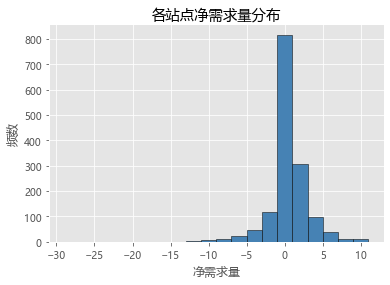

In [20]:
# 净借量分布图
X_Demand = pd.DataFrame(X_dict_borrow.values(),index = X_dict_borrow.keys(),columns=['borrow'])
X_Demand['return'] = pd.Series(X_dict_return)
X_Demand['net_demand'] = X_Demand['borrow']-X_Demand['return']

#plt.rcParams['axes.unicode_minus']=False#坐标轴负号的处理
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']#处理中文乱码
plt.style.use('ggplot')#设置绘图风格
X_Demand['net_demand'].plot(kind = 'hist', bins = 20, color = 'steelblue', edgecolor = 'black', density = False)
plt.xlabel('净需求量')
plt.ylabel('频数')
plt.title('各站点净需求量分布')

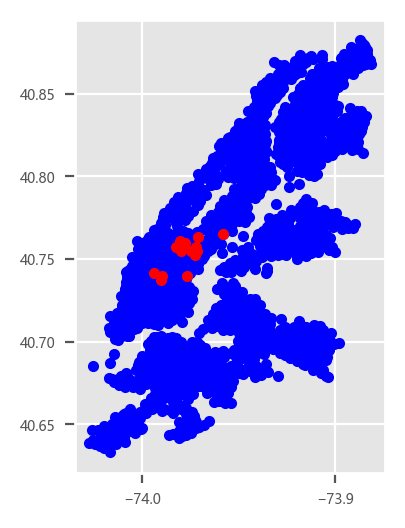

<Figure size 432x288 with 0 Axes>

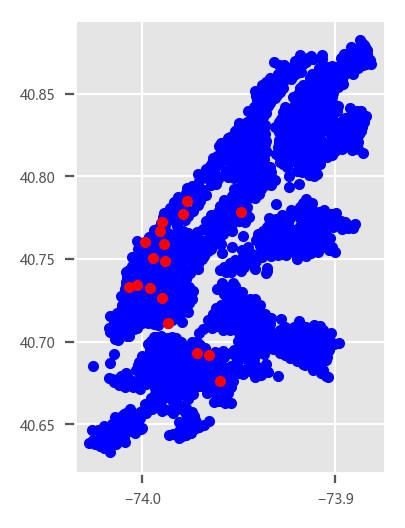

In [21]:
# 画图 验证猜想   解释 左尾长，右尾短
sample0 = pd.read_csv("E:/CitiBike/y2_output/sample_SET.csv",index_col=0)
sta_loc4 = sample0[sample0['date']==today][['station_id','lat','lon']]#站点坐标数据
X_Demand['station_id'] = X_Demand.index
X_Demand.index = range(len(X_Demand))
X_Demand = pd.merge(X_Demand,sta_loc4,on='station_id')#与状态数据合并

plt.figure(dpi=200,figsize=(2,3))
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

temp1 = X_Demand[X_Demand['net_demand']>=8]
temp2 = X_Demand[X_Demand['net_demand']<=-10]
plt.figure(1)
plt.plot(sta_loc4['lon'],sta_loc4['lat'],'b.')
plt.plot(temp2['lon'],temp2['lat'],'r.')
plt.figure(2)
plt.figure(dpi=200,figsize=(2,3))
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.plot(sta_loc4['lon'],sta_loc4['lat'],'b.')
plt.plot(temp1['lon'],temp1['lat'],'r.')